[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/donishadsmith/neurocaps/blob/stable/demos/simulated_demo.ipynb)

<font size="6">Logging</font>

 <font size="3">Default logging configurations are provided by NeuroCAPs, which sends logged messages to standard output. However, optionally, logging can be configured prior to package import. For more information about configuring logging, , especially for logging with parallel processing, refer to [NeuroCAPs' Logging Documentation](https://neurocaps.readthedocs.io/en/stable/logging.html).</font>

In [1]:
# Changing from default logger prior to package import
import logging

try:
    from rich.logging import RichHandler

    handler = RichHandler()

    logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(name)s [%(levelname)s] %(message)s",
    handlers=[handler],
    )
except:
    pass

In [2]:
# Download packages
try:
    import neurocaps
except:
    !pip install neurocaps[windows,demo]

# Set headless display for google colab
import os, sys

if "google.colab" in sys.modules:
    os.environ["DISPLAY"] = ":0.0"
    !apt-get install -y xvfb
    !Xvfb :0 -screen 0 1024x768x24 &> /dev/null &
    !Xvfb :0 -screen 0 1024x768x24 &> /dev/null &

c:\Users\donis\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\donis\AppData\Local\Programs\Python\Python313\Lib\site-packages\neuromaps\datasets\utils.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [3]:
import os, sys
import plotly.io as pio

import numpy as np

# To show static plotly images so that they can be displayed on the saved Jupyter notebook on Github
pio.renderers.default = "svg"

<font size="6">Create Simulated Dataset</font>

 <font size="3">The following function created a basic fMRIPrep dataset.</font>

In [4]:
from neurocaps.utils import simulate_bids_dataset

bids_dir = simulate_bids_dataset(
    n_subs=2,
    n_runs=1,
    n_volumes=40,
    task_name="rest",
    output_dir=os.path.join(os.getcwd(), "neurocaps_demo")
    )

[01/27/26 14:06:08] WARNING  2026-01-27 14:06:08,392 neurocaps.utils._io [WARNING] Creating the following ]8;id=831795;file://C:\Users\donis\Github\neurocaps\neurocaps\utils\_io.py\_io.py]8;;\:]8;id=707382;file://C:\Users\donis\Github\neurocaps\neurocaps\utils\_io.py#22\22]8;;\
                             non-existent path:                                                                    
                             c:\Users\donis\Github\neurocaps\demos\neurocaps_demo\derivatives\fmriprep.            

<font size="6">Timeseries Extraction</font>

 <font size="3">To demonstrate timeseries extraction using the `TimeseriesExtractor` class, the single subject dataset used to test the NeuroCAPs package will be downloaded for demonstration. For the timeseries extraction to work, the PyBIDS package must be installed. To install PyBIDS on Windows, you can use `pip install pybids`
 or `pip install neurocaps[windows]`. Additionally, for PyBIDS installation on Windows, you may need to enable long path support. The instructions to do so, involves right clicking on Powershell, selecting "Run as Administrator", and pasting in the Powershell command located in the official [Microsoft documentation](https://learn.microsoft.com/en-us/windows/win32/fileio/maximum-file-path-limitation?tabs=powershell). An alternative involves installing [Windows Subsytem for Linux (WSL)](https://code.visualstudio.com/docs/remote/wsl-tutorial) and [opening jupyter notebook from the Ubuntu terminal](https://saturncloud.io/blog/how-to-install-jupyter-notebook-in-ubuntu/). </font>

In [5]:
from neurocaps.extraction import TimeseriesExtractor
from neurocaps.analysis import CAP, merge_dicts, standardize, change_dtype

# Can use atlases in Schaefer and AAL
parcel_approach = {"Schaefer": {"n_rois": 100}}
# parcel_approach = {"AAL": {"version": "SPM12"}}

ncol = (
    parcel_approach["Schaefer"]["n_rois"]
    if "Schaefer" in parcel_approach.keys()
    else (116 if parcel_approach["AAL"]["version"] != "3v2" else 166)
)

# Adding an asterisk results in all columns starting with name preceding the asterisk to be
# extracted for nuisance regression
confounds = ["cosine*", "rot*"]

# Set up signal cleaning parameters
extractor = TimeseriesExtractor(
    space="MNI152NLin2009cAsym",
    parcel_approach=parcel_approach,
    standardize=False,
    use_confounds=True,
    low_pass=0.15,
    confound_names=confounds,
    dummy_scans=5,
    fd_threshold={"threshold": 0.90, "outlier_percentage": 0.30, "interpolate": True},
)

# Perform the timeseries extraction; only one session can be extracted at a time.
# Internally, lru_cache is used for ``BidsLayout``. May need to clear cache if the cell was ran
# before the directory download completed
extractor.get_bold(
    bids_dir=bids_dir,
    task="rest",
    n_cores=None,
    tr=1.2,
    verbose=True,
    progress_bar=True,
)

# Standardize extracted timeseries of all subjects in ``extractor.subject_timeseries``
# if not done in ``TimeseriesExtractor``
subject_timeseries_dict = standardize(
    subject_timeseries_list=[extractor.subject_timeseries], return_dicts=True
)

# Increase or decrease the dtype; recommend not going lower than float32; this function is
# intended to decrease `subject_timeseries` from float64 to float32 for memory saving purposes 
# hile maintaining precision.
subject_timeseries_dict = change_dtype(
    subject_timeseries_list=[subject_timeseries_dict["dict_0"]], dtype="float32"
)

# extractor.subject_timeseries is also a setter
extractor.subject_timeseries = subject_timeseries_dict["dict_0"]

[01/27/26 14:06:27] WARNING  2026-01-27 14:06:27,105                                ]8;id=26870;file://C:\Users\donis\Github\neurocaps\neurocaps\utils\_parcellation_validation.py\_parcellation_validation.py]8;;\:]8;id=33257;file://C:\Users\donis\Github\neurocaps\neurocaps\utils\_parcellation_validation.py#185\185]8;;\
                             neurocaps.utils._parcellation_validation [WARNING]                                    
                             'yeo_networks' not specified in `parcel_approach`.                                    
                             Defaulting to 7 networks.                                                             

                    WARNING  2026-01-27 14:06:27,107                                ]8;id=727390;file://C:\Users\donis\Github\neurocaps\neurocaps\utils\_parcellation_validation.py\_parcellation_validation.py]8;;\:]8;id=196085;file://C:\Users\donis\Github\neurocaps\neurocaps\utils\_parcellation_validation.py#189\189]8;;\
                             neurocaps.utils._parcellation_validation [WARNING]                                    
                             'resolution_mm' not specified in `parcel_approach`.                                   
                             Defaulting to 1mm.                                                                    

                    INFO     2026-01-27 14:06:27,283 neurocaps.extraction._internals.confounds      ]8;id=719665;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\confounds.py\confounds.py]8;;\:]8;id=988513;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\confounds.py#68\68]8;;\
                             [INFO] Confound regressors to be used if available: cosine*, rot*.                    

                    INFO     2026-01-27 14:06:27,581                                    ]8;id=159626;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\timeseries_extractor.py\timeseries_extractor.py]8;;\:]8;id=130209;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\timeseries_extractor.py#814\814]8;;\
                             neurocaps.extraction.timeseries_extractor [INFO] BIDS                                 
                             Layout: ...neurocaps\demos\neurocaps_demo | Subjects: 0 |                             
                             Sessions: 0 | Runs: 0                                                                 

Processing Subjects:   0%|          | 0/2 [00:00<?, ?it/s]

                    INFO     2026-01-27 14:06:27,618 neurocaps.extraction._internals.postprocess ]8;id=976679;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=204325;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#302\302]8;;\
                             [INFO] [SUBJECT: 0 | SESSION: None | TASK: rest | RUN: 0] Preparing                   
                             for Timeseries Extraction using [FILE:                                                
                             sub-0_task-rest_run-0_space-MNI152NLin2009cAsym_desc-preproc_bold.n                   
                             ii.gz].                                                                               

                    INFO     2026-01-27 14:06:27,636 neurocaps.extraction._internals.postprocess ]8;id=440436;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=184030;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#823\823]8;;\
                             [INFO] [SUBJECT: 0 | SESSION: None | TASK: rest | RUN: 0] The                         
                             following confounds will be used for nuisance regression:                             
                             cosine_00, cosine_01, cosine_02, cosine_03, cosine_04, cosine_05,                     
                             cosine_06, rot_x, rot_y, rot_z.                                                       

Processing Subjects:  50%|█████     | 1/2 [00:04<00:04,  4.07s/it]

[01/27/26 14:06:31] INFO     2026-01-27 14:06:31,692 neurocaps.extraction._internals.postprocess ]8;id=580957;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=104484;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#302\302]8;;\
                             [INFO] [SUBJECT: 1 | SESSION: None | TASK: rest | RUN: 0] Preparing                   
                             for Timeseries Extraction using [FILE:                                                
                             sub-1_task-rest_run-0_space-MNI152NLin2009cAsym_desc-preproc_bold.n                   
                             ii.gz].                                                                               

                    INFO     2026-01-27 14:06:31,717 neurocaps.extraction._internals.postprocess ]8;id=484503;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=639590;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#823\823]8;;\
                             [INFO] [SUBJECT: 1 | SESSION: None | TASK: rest | RUN: 0] The                         
                             following confounds will be used for nuisance regression:                             
                             cosine_00, cosine_01, cosine_02, cosine_03, cosine_04, cosine_05,                     
                             cosine_06, rot_x, rot_y, rot_z.                                                       

Processing Subjects: 100%|██████████| 2/2 [00:08<00:00,  4.07s/it]


In [6]:
# Print metadata
print(extractor)

Current Object State:
Preprocessed BOLD Template Space                           : MNI152NLin2009cAsym
Parcellation Approach                                      : Schaefer
Signal Cleaning Parameters                                 : {'masker_init': {'detrend': False, 'low_pass': 0.15, 'high_pass': None, 'smoothing_fwhm': None}, 'standardize': False, 'use_confounds': True, 'confound_names': ['cosine*', 'rot*'], 'n_acompcor_separate': None, 'dummy_scans': 5, 'fd_threshold': {'threshold': 0.9, 'outlier_percentage': 0.3, 'interpolate': True}, 'dtype': None}
Task Information                                           : {'task': 'rest', 'session': None, 'runs': None, 'condition': None, 'condition_tr_shift': 0, 'tr': 1.2, 'slice_time_ref': 0.0}
Number of Subjects                                         : 2
CPU Cores Used for Timeseries Extraction (Multiprocessing) : None
Subject Timeseries Byte Size                               : 27384 bytes


In [7]:
import neurocaps

neurocaps.__version__

'0.36.2'

<font size="6">Checking Quality Control Metrics</font>

<font size="3">Checking statistics on framewise displacement and dummy volumes using the `self.report_qc` method. Only censored frames with valid data on both sides are interpolated, while censored frames at the edge of the timeseries (including frames that border censored edges) are always scrubbed and counted in "Frames_Scrubbed". In the data, the last frame is the only one with an FD > 0.35. Additionally, [scipy's Cubic Spline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html) is used to only interpolate censored frames.</font>

In [8]:
df = extractor.report_qc()
df

,Subject_ID,Run,Mean_FD,Std_FD,Frames_Scrubbed,Frames_Interpolated,Mean_High_Motion_Length,Std_High_Motion_Length,N_Dummy_Scans
0,0,run-0,0.583948,0.273400,0,5,1.25,0.433013,5
1,1,run-0,0.463917,0.282579,2,1,1.50,0.500000,5


<font size="6">BOLD Visualization</font>

<font size="3">Visualizing bold data using the `self.visualize_bold` method.</font>

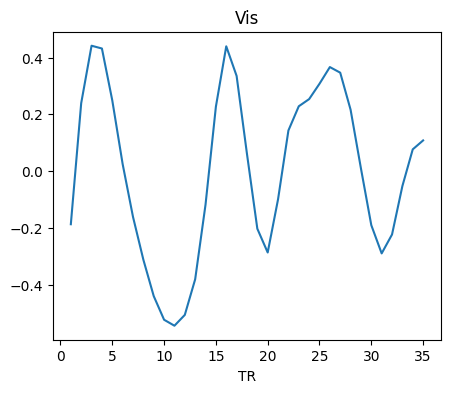

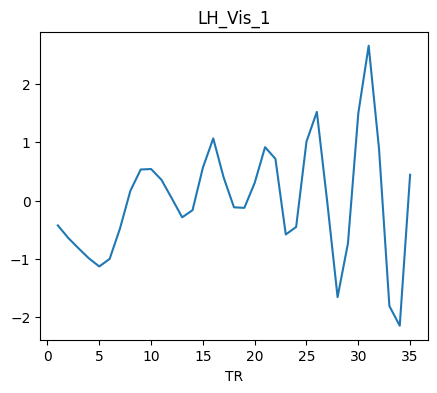

In [9]:
from neurocaps.utils import PlotDefaults

plot_kwargs = PlotDefaults.visualize_bold()
plot_kwargs.update({"figsize": (5, 4)})

if "AAL" in parcel_approach:
    extractor.visualize_bold(subj_id="0", run="0", region="Precentral", **plot_kwargs)

    extractor.visualize_bold(subj_id="0", run="0", roi_indx=0, **plot_kwargs)
else:
    extractor.visualize_bold(subj_id="0", run="0", region="Vis", **plot_kwargs)

    extractor.visualize_bold(subj_id="0", run="0", roi_indx="LH_Vis_1", **plot_kwargs)

 <font size="6">Saving Timeseries as Pickle</font>
 
 <font size="3">`self.get_bold` produces a nested dictionary structure containing the subject id, run id, and the associated timeseries data. This nested dictionary is stored in the `self.subject_timeseries` attribute and can be saved as a pickle file using `self.timeseries_to_pickle`.</font>

In [10]:
output_dir = "neurocaps_demo"
extractor.timeseries_to_pickle(
    output_dir=output_dir, filename="sample_for_neurocaps_demo_timeseries.pkl"
)

 <font size="6">Co-Activation Patterns (CAPs) With No Groups</font>
 
 <font size="3">Initializing the `CAP` class and using the saved pickle file as input for `self.get_caps`.  When group is `None`, which is the default value of this parameter, then the default group name is "All Subjects".</font>

[01/27/26 14:06:35] INFO     2026-01-27 14:06:35,929 neurocaps.analysis.cap._internals.cluster [INFO] ]8;id=42498;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py\cluster.py]8;;\:]8;id=764179;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py#47\47]8;;\
                             No groups specified. Using default group 'All Subjects' containing all                
                             subject IDs from `subject_timeseries`. The `groups` dictionary will                   
                             remain fixed unless the `CAP` class is re-initialized or                              
                             `clear_groups()` is used.                                                             

[01/27/26 14:06:37] INFO     2026-01-27 14:06:37,416 neurocaps.analysis.cap._internals.cluster       ]8;id=718290;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py\cluster.py]8;;\:]8;id=881753;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py#281\281]8;;\
                             [INFO] [GROUP: All Subjects | METHOD: davies_bouldin] Optimal cluster                 
                             size is 5.                                                                            

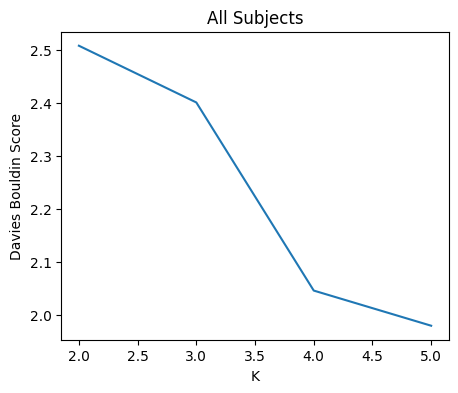

In [11]:
# `parcel_approach` is only required for certain visualization functions and can be set later
# cap_analysis = CAP(parcel_approach = {"Schaefer": {"n_rois": 100}})
from neurocaps.utils import PlotDefaults

cap_analysis = CAP(extractor.parcel_approach, groups=None)

plot_kwargs = PlotDefaults.get_caps()
plot_kwargs["figsize"] = (5, 4)

cap_analysis.get_caps(
    subject_timeseries=os.path.join(output_dir, "sample_for_neurocaps_demo_timeseries.pkl"),
    n_clusters=range(2, 6),  # Test k=2 to k=5
    random_state=0,
    standardize=True,
    cluster_selection_method="davies_bouldin",
    show_figs=True,
    **plot_kwargs,
)

# The concatenated data can be safely deleted since only the kmeans models and any standardization
# parameters are used for computing temporal metrics.

del cap_analysis.concatenated_timeseries

In [12]:
# Print metadata
print(cap_analysis)

Current Object State:
Parcellation Approach                                       : Schaefer
Groups                                                      : All Subjects
Number of Clusters                                          : [2, 3, 4, 5]
Cluster Selection Method                                    : davies_bouldin
Optimal Number of Clusters (if Range of Clusters Provided)  : {'All Subjects': 5}
CPU Cores Used for Clustering (Multiprocessing)             : None
User-Specified Runs IDs Used for Clustering                 : None
Concatenated Timeseries Bytes                               : 0 bytes
Standardized Concatenated Timeseries                        : True
Co-Activation Patterns (CAPs)                               : {'All Subjects': 5}
Variance Explained by Clustering                            : {'All Subjects': np.float32(0.28721082)}


<font size="6">Return CAP Labels for Each Subject</font>

In [13]:
cap_labels_dict = cap_analysis.return_cap_labels(
    subject_timeseries=os.path.join(output_dir, "sample_for_neurocaps_demo_timeseries.pkl")
)

cap_labels_dict

{'0': {'run-0': array([3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2], dtype=int32)},
 '1': {'run-0': array([1, 0, 0, 3, 1, 1, 1, 2, 2, 2, 1, 0, 4, 4, 4, 3, 0, 0, 0, 3, 3, 3,
         3, 3, 3, 3, 2, 2, 4, 4, 4, 1, 1], dtype=int32)}}

 <font size="6">Calculating CAP Metrics With No Groups</font>

 <font size="3">Getting CAP metrics using the `self.calculate_metrics` method. Available metrics includes "counts", "temporal_fraction", "persistence", "transition_frequency", and "transition_probability".</font>

In [14]:
# Get metric for the single subject in this `subject_timeseries` pickle file
cap_analysis.calculate_metrics(
    subject_timeseries=os.path.join(output_dir, "sample_for_neurocaps_demo_timeseries.pkl"),
    metrics="persistence",
)["persistence"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3,CAP-4,CAP-5
0,0,All Subjects,run-0,0.0,0.00,4.25,4.5,0.0
1,1,All Subjects,run-0,2.0,1.75,2.50,3.0,3.0


 <font size="6">Co-Activation Patterns (CAPs) With Groups</font>
 
 <font size="3">Performing CAP analysis for two groups using the `groups` parameter when initializing the `CAP` class. Also finding the optimal cluster size for each group by using the elbow method. Additional options for `cluster_selection_method` includes the "silhouette", "davies_bouldin", and "variance_ratio". Additionally, visualizations from any method that produces them can be saved using `output_dir`, all methods have docstrings explaining their purpose, available parameters, kwargs, and properties (in the case of classes). For demonstration purposes, a simulated `subject_timeseries` is created. Below, clustering is based on only run-1 and run-2 timeseries data from `subject_timeseries`.</font>

                    WARNING  2026-01-27 14:06:37,536                                ]8;id=200667;file://C:\Users\donis\Github\neurocaps\neurocaps\utils\_parcellation_validation.py\_parcellation_validation.py]8;;\:]8;id=184089;file://C:\Users\donis\Github\neurocaps\neurocaps\utils\_parcellation_validation.py#185\185]8;;\
                             neurocaps.utils._parcellation_validation [WARNING]                                    
                             'yeo_networks' not specified in `parcel_approach`.                                    
                             Defaulting to 7 networks.                                                             

                    WARNING  2026-01-27 14:06:37,539                                ]8;id=16019;file://C:\Users\donis\Github\neurocaps\neurocaps\utils\_parcellation_validation.py\_parcellation_validation.py]8;;\:]8;id=391701;file://C:\Users\donis\Github\neurocaps\neurocaps\utils\_parcellation_validation.py#189\189]8;;\
                             neurocaps.utils._parcellation_validation [WARNING]                                    
                             'resolution_mm' not specified in `parcel_approach`.                                   
                             Defaulting to 1mm.                                                                    

Clustering [GROUP: High ADHD]: 100%|██████████| 23/23 [00:03<00:00,  6.99it/s]


[01/27/26 14:06:41] INFO     2026-01-27 14:06:41,072 neurocaps.analysis.cap._internals.cluster       ]8;id=103425;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py\cluster.py]8;;\:]8;id=464348;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py#281\281]8;;\
                             [INFO] [GROUP: High ADHD | METHOD: silhouette] Optimal cluster size is                
                             2.                                                                                    

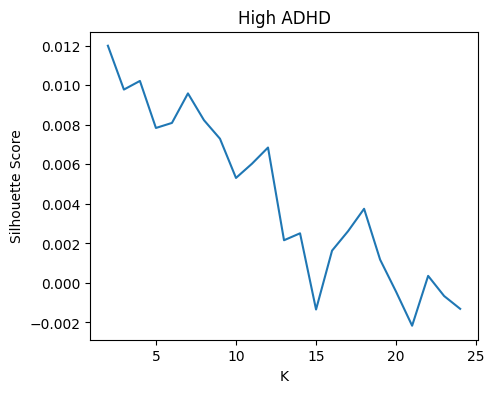

Clustering [GROUP: Low ADHD]: 100%|██████████| 23/23 [00:00<00:00, 167.59it/s]


                    INFO     2026-01-27 14:06:41,305 neurocaps.analysis.cap._internals.cluster       ]8;id=572237;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py\cluster.py]8;;\:]8;id=759298;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py#281\281]8;;\
                             [INFO] [GROUP: Low ADHD | METHOD: silhouette] Optimal cluster size is                 
                             2.                                                                                    

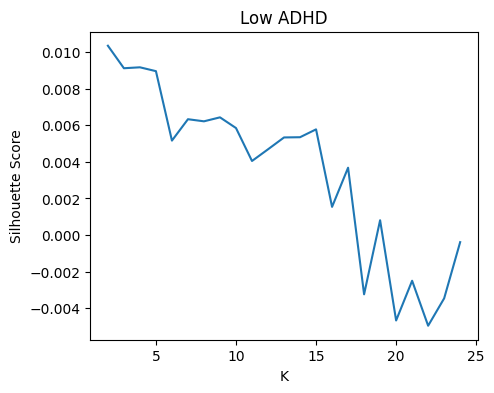

In [15]:
# Simulating a nested dictionary structure containing group data
from neurocaps.utils import simulate_subject_timeseries

subject_timeseries = simulate_subject_timeseries(n_subs=8, n_runs=3, shape=(50, ncol))

# Initializing CAP class and performing the elbow method
cap_analysis = CAP(
    groups={
        "High ADHD": ["0", "1", "2", "3"],
        "Low ADHD": ["4", "5", "6", "7"],
    }
)

# Setting parcel approach instead of assigning it during initialization of the CAP class
cap_analysis.parcel_approach = parcel_approach

plot_kwargs = PlotDefaults.get_caps()
plot_kwargs.update({"figsize": (5, 4)})

cap_analysis.get_caps(
    subject_timeseries=subject_timeseries,
    runs=[1, 2],
    n_clusters=range(2, 25),
    cluster_selection_method="silhouette",
    n_cores=2,  # Used when `n_clusters` is a list, to run multiple kmeans simultaneously
    show_figs=True,
    progress_bar=True,
    **plot_kwargs,
)

In [16]:
# Print metadata
print(cap_analysis)

Current Object State:
Parcellation Approach                                       : Schaefer
Groups                                                      : High ADHD, Low ADHD
Number of Clusters                                          : [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
Cluster Selection Method                                    : silhouette
Optimal Number of Clusters (if Range of Clusters Provided)  : {'High ADHD': 2, 'Low ADHD': 2}
CPU Cores Used for Clustering (Multiprocessing)             : 2
User-Specified Runs IDs Used for Clustering                 : [1, 2]
Concatenated Timeseries Bytes                               : 640184 bytes
Standardized Concatenated Timeseries                        : True
Co-Activation Patterns (CAPs)                               : {'High ADHD': 2, 'Low ADHD': 2}
Variance Explained by Clustering                            : {'High ADHD': np.float64(0.014696361624391474), 'Low ADHD': np.float64(0.0136153

<font size="6">Calculating CAPs Metrics With Groups</font>

 <font size="3">Note, all groups are in the same dataframe for simplicity purposes (except for "transition_probability" where each group has separate dataframes) but use their own kmeans models to calculate each metric. Consequently, "CAP-1" and "CAP-2" are different for each group. In cases where the optimal cluster size for each group differs, values assigned as NaN is just indicates that a group does not have a particular CAP. This done to differentiate it from 0, which indicates a particular CAP did not appear in a subject.
 
 Furthermore, a `run` parameter is offered in `calculate_metrics`. Despite clustering only being done on the first two runs, any run combination can be selected.</font>

In [17]:
cap_analysis.calculate_metrics(subject_timeseries=subject_timeseries, runs=[1, 2])[
    "temporal_fraction"
]

,Subject_ID,Group,Run,CAP-1,CAP-2
0,0,High ADHD,run-1,0.38,0.62
1,0,High ADHD,run-2,0.42,0.58
2,1,High ADHD,run-1,0.32,0.68
3,1,High ADHD,run-2,0.58,0.42
4,2,High ADHD,run-1,0.46,0.54
5,2,High ADHD,run-2,0.34,0.66
6,3,High ADHD,run-1,0.44,0.56
7,3,High ADHD,run-2,0.38,0.62
8,4,Low ADHD,run-1,0.40,0.60
9,4,Low ADHD,run-2,0.36,0.64


<font size="3">The first two runs are selected and treated as continuous, the reduce the number of downstream statistical analyses.</font>

In [18]:
cap_analysis.calculate_metrics(
    subject_timeseries=subject_timeseries, runs=[1, 2], continuous_runs=True
)["counts"]

,Subject_ID,Group,Run,CAP-1,CAP-2
0,0,High ADHD,run-continuous,23,23
1,1,High ADHD,run-continuous,27,27
2,2,High ADHD,run-continuous,27,27
3,3,High ADHD,run-continuous,26,25
4,4,Low ADHD,run-continuous,23,24
5,5,Low ADHD,run-continuous,23,23
6,6,Low ADHD,run-continuous,27,27
7,7,Low ADHD,run-continuous,26,26


 <font size="6">Calculating CAP Metrics and Treating Separate Runs as Continuous Runs </font>

In [19]:
metrics = cap_analysis.calculate_metrics(
    subject_timeseries=subject_timeseries,
    metrics="transition_probability",
    runs=[1],
)

metrics["transition_probability"]["High ADHD"]

,Subject_ID,Group,Run,1.1,1.2,2.1,2.2
0,0,High ADHD,run-1,0.388889,0.611111,0.354839,0.645161
1,1,High ADHD,run-1,0.200000,0.800000,0.352941,0.647059
2,2,High ADHD,run-1,0.391304,0.608696,0.500000,0.500000
3,3,High ADHD,run-1,0.476190,0.523810,0.392857,0.607143


  <font size="6">Transition Probability Matrix</font>
  
 <font size="3">`transition_matrix` can be used to generate and visualize the averaged transition probabilities for each group. </font>

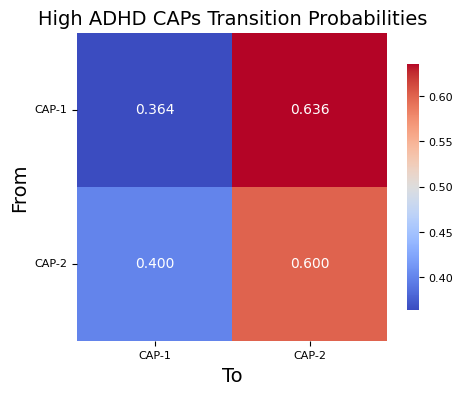

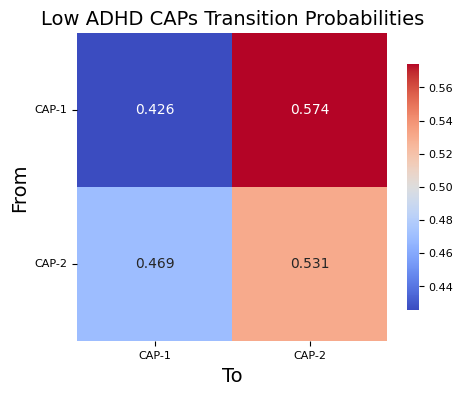

,CAP-1,CAP-2
From/To,,
CAP-1,0.425501,0.574499
CAP-2,0.469445,0.530555


In [20]:
from neurocaps.analysis import transition_matrix

plot_kwargs = PlotDefaults.transition_matrix()
plot_kwargs.update({"annot": True, "fmt": ".3f", "figsize": (5, 4)})

trans_df = transition_matrix(
    trans_dict=metrics["transition_probability"],
    return_df=True,
    show_figs=True,
    **plot_kwargs,
)

trans_df["Low ADHD"]

<font size="6">Plotting CAPs as Outer Products and Heatmaps </font>

 <font size="3">Visualizing CAPs as outer product heatmap at the regional/network level using `self.caps2plot` method.</font>

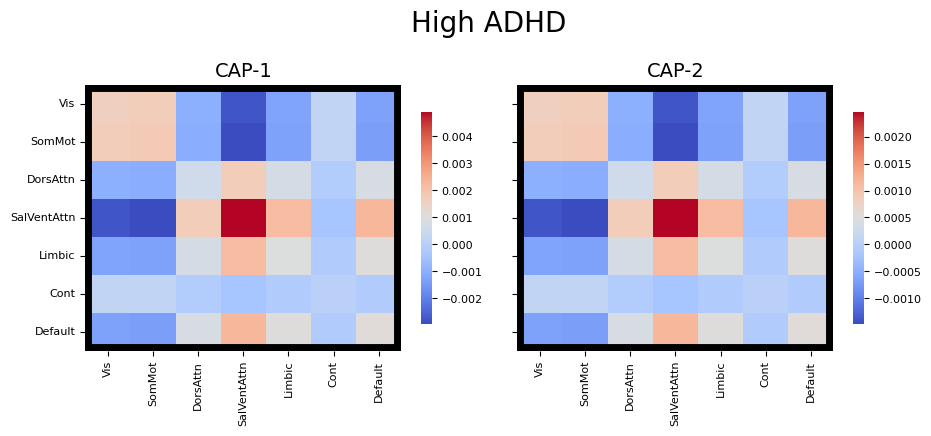

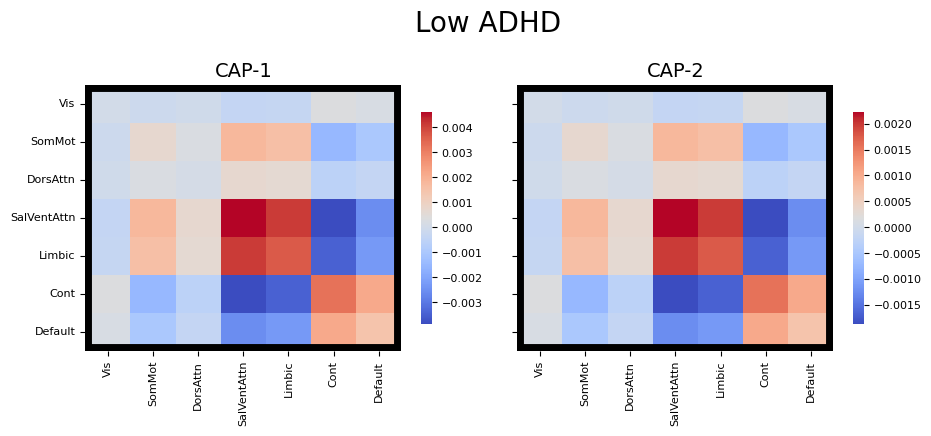

In [21]:
plot_kwargs = PlotDefaults.caps2plot()
plot_kwargs.update({"xlabel_rotation": 90, "sharey": True, "borderwidths": 10, "figsize": (9, 4)})

cap_analysis.caps2plot(
    plot_options="outer_product",
    subplots=True,
    **plot_kwargs,
)

 <font size="3">Visualizing CAPs as outer product heatmap at the node level using `self.caps2plot` method.</font>

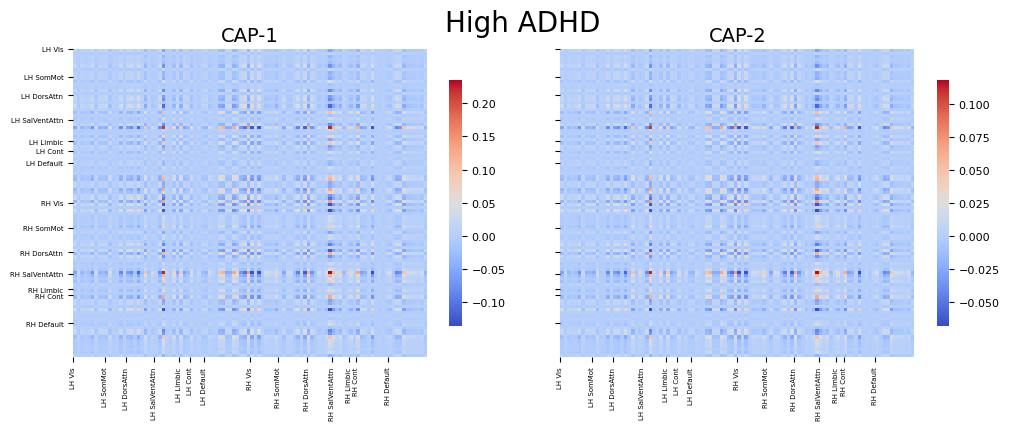

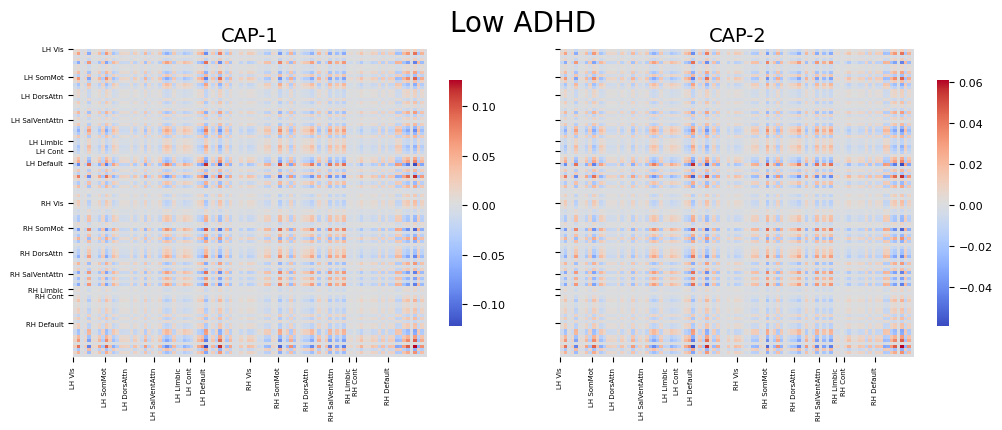

In [22]:
plot_kwargs = PlotDefaults.caps2plot()
plot_kwargs.update(
    {
        "yticklabels_size": 5,
        "wspace": 0.1,
        "hspace": 0.6,
        "xlabel_rotation": 90,
        "xticklabels_size": 5,
        "tight_layout": False,
        "figsize": (12, 4),
    }
)

cap_analysis.caps2plot(
    plot_options="outer_product",
    visual_scope="nodes",
    subplots=True,
    **plot_kwargs,
)

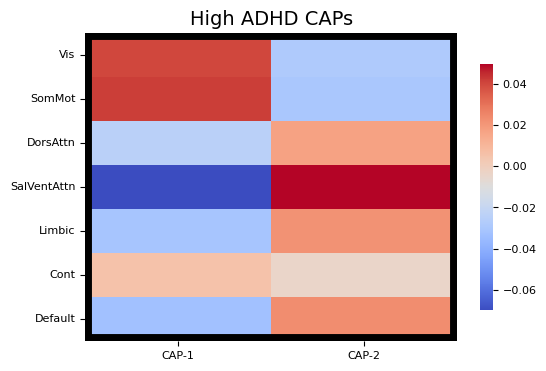

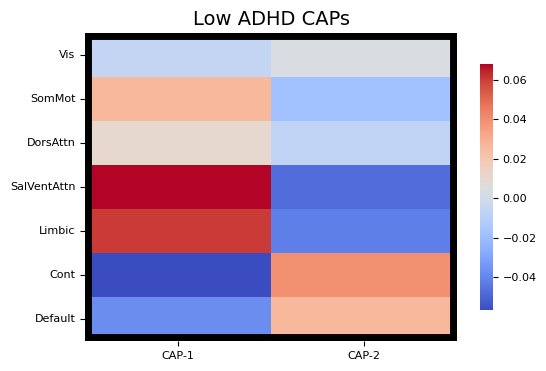

In [23]:
plot_kwargs = PlotDefaults.caps2plot()
plot_kwargs.update({"borderwidths": 10, "figsize": (6, 4)})

cap_analysis.caps2plot(
    visual_scope="regions",
    plot_options="heatmap",
    subplots=True,
    **plot_kwargs,
)

 <font size="6">Merging Different Timeseries Across Sessions or Tasks </font>

 <font size="3">Using `merge_dicts` to merge common subjects across different subject timeseries dictionaries. This is to allow CAPs to be estimated on the merged dictionary (for similar CAPs across tasks or sessions) and for metrics to be calculated for each of the individual dictionaries. For instance, `subject_timeseries_1` may be the extracted timeseries from session 1 and `subject_timeseries_2` are the extracted timeseries for session 2. When merged, only subjects that have at least a single run across sessions will be returned in the merged dictionary. When `return_reduced_dicts` is True, only the subjects in the merged dictionary will be returned for the reduced dictionaries. In this example "dict_0" is the reduced form of `subject_timeseries_1` and "dict_1" is the reduced form of `subject_timeseries_2`. So, "merged" can be used as the input to estimate common CAPs across sessions for `get_caps` and "dict_0" and "dict_1" can be used as inputs for `self.calculate_metrics` to obtain the metrics for the CAPs for each session.</font>

In [24]:
# Simulating two separate `subject_timeseries`

subject_timeseries_1 = simulate_subject_timeseries(n_subs=10, n_runs=3, shape=(100, 400))
subject_timeseries_2 = simulate_subject_timeseries(n_subs=8, n_runs=3, shape=(100, 400))

# Returns merged dictionary as well as the reduced subject dictionaries containing only the
# subjects present in the merged
all_dicts = merge_dicts(
    subject_timeseries_list=[subject_timeseries_1, subject_timeseries_2],
    return_merged_dict=True,
    return_reduced_dicts=True,
)

print(all_dicts["dict_0"].keys())
print(all_dicts["dict_1"].keys())
print(all_dicts["merged"].keys())

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7'])
dict_keys(['0', '1', '2', '3', '4', '5', '6', '7'])
dict_keys(['0', '1', '2', '3', '4', '5', '6', '7'])


 <font size="6">Identifying CAPs in Merged Timeseries </font>

 <font size="3">Generating examples not using the `group` parameter. Note, some additional plotting and non-plotting methods are shown below, all methods in the `CAP` class works regardless if `group` is None or defined since plots are generated for each group. The merged timeseries in `all_dicts` which was generated in the previous cell will be used as input here.</font>

In [25]:
cap_analysis = CAP(
    parcel_approach={"Schaefer": {"n_rois": 400, "resolution_mm": 1, "yeo_networks": 7}}
)

cap_analysis.get_caps(subject_timeseries=all_dicts["merged"], n_clusters=3)

[01/27/26 14:06:42] INFO     2026-01-27 14:06:42,575 neurocaps.analysis.cap._internals.cluster [INFO] ]8;id=871151;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py\cluster.py]8;;\:]8;id=469097;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py#47\47]8;;\
                             No groups specified. Using default group 'All Subjects' containing all                
                             subject IDs from `subject_timeseries`. The `groups` dictionary will                   
                             remain fixed unless the `CAP` class is re-initialized or                              
                             `clear_groups()` is used.                                                             

 <font size="6">Calculating CAP Metrics on Subsets of Merged Timeseries </font>

In [26]:
output = cap_analysis.calculate_metrics(
    subject_timeseries=all_dicts["dict_0"], return_df=True, runs=[1, 2]
)

output["temporal_fraction"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3
0,0,All Subjects,run-1,0.28,0.35,0.37
1,0,All Subjects,run-2,0.31,0.28,0.41
2,1,All Subjects,run-1,0.31,0.40,0.29
3,1,All Subjects,run-2,0.39,0.32,0.29
4,2,All Subjects,run-1,0.32,0.31,0.37
5,2,All Subjects,run-2,0.32,0.36,0.32
6,3,All Subjects,run-1,0.40,0.26,0.34
7,3,All Subjects,run-2,0.27,0.36,0.37
8,4,All Subjects,run-1,0.34,0.29,0.37
9,4,All Subjects,run-2,0.32,0.36,0.32


In [27]:
output = cap_analysis.calculate_metrics(
    subject_timeseries=all_dicts["dict_1"],
    return_df=True,
    runs=[1, 2],
    continuous_runs=True,
)

output["persistence"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3
0,0,All Subjects,run-continuous,1.431373,1.363636,1.675000
1,1,All Subjects,run-continuous,1.521739,1.476190,1.511111
2,2,All Subjects,run-continuous,1.512195,1.428571,1.545455
3,3,All Subjects,run-continuous,1.543478,1.326087,1.387755
4,4,All Subjects,run-continuous,1.280000,1.365385,1.710526
5,5,All Subjects,run-continuous,1.659574,1.534884,1.600000
6,6,All Subjects,run-continuous,1.755556,1.463415,1.452381
7,7,All Subjects,run-continuous,1.410256,1.454545,1.760870


In [28]:
output = cap_analysis.calculate_metrics(
    subject_timeseries=all_dicts["dict_1"], return_df=True, runs=[1, 2]
)

output["transition_frequency"]

,Subject_ID,Group,Run,Transition_Frequency
0,0,All Subjects,run-1,65
1,0,All Subjects,run-2,68
2,1,All Subjects,run-1,62
3,1,All Subjects,run-2,70
4,2,All Subjects,run-1,70
5,2,All Subjects,run-2,62
6,3,All Subjects,run-1,69
7,3,All Subjects,run-2,70
8,4,All Subjects,run-1,71
9,4,All Subjects,run-2,67


<font size="6">CAPs Correlation Matrix </font>

 <font size="3">`self.caps2corr` can be used to obtain the Pearson or Spearman correlation between CAPs and to obtain a dataframe of the uncorrected p-values.</font>

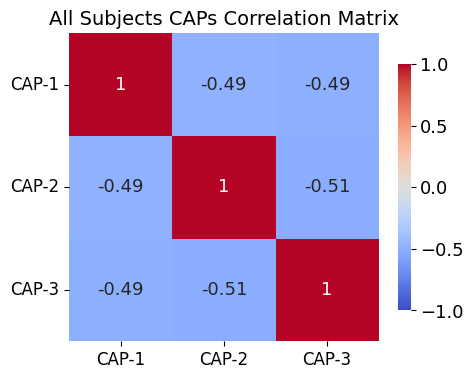

,CAP-1,CAP-2,CAP-3
CAP-1,1 (0)***,-0.49 (9.3e-26)***,-0.49 (5.3e-26)***
CAP-2,-0.49 (9.3e-26)***,1 (0)***,-0.51 (2.4e-28)***
CAP-3,-0.49 (5.3e-26)***,-0.51 (2.4e-28)***,1 (0)***


In [29]:
plot_kwargs = PlotDefaults.caps2corr()
plot_kwargs.update(
    {
        "annot": True,
        "figsize": (5, 4),
        "xticklabels_size": 12,
        "yticklabels_size": 12,
        "vmin": -1,
        "vmax": 1,
        "annot_kws": {"size": 13},
        "cbarlabels_size": 13,
    }
)

corr_df = cap_analysis.caps2corr(
    method="pearson",
    return_df=True,
    **plot_kwargs,
)

corr_df["All Subjects"]

 <font size="6">CAPs Surface Plots </font> 
 
 <font size="3">Visualizing CAPs as surface plots using `self.caps2surf` method.</font>

 <font size="3">**Note:** If the ``color_range`` kwarg is not used, each CAP will be scaled to its own maximum and minimum value. For directly comparable, zero-centered images, it is recommended to set a symmetric ``color_range`` based on the largest absolute value across all CAPs (e.g., if the largest absolute value is 0.96, use ``color_range=(-0.21, 0.21)``).</font>

[01/27/26 14:06:45] WARNING  2026-01-27 14:06:45,438 neurocaps.analysis.cap._internals.surface        ]8;id=878491;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\surface.py\surface.py]8;;\:]8;id=81979;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\surface.py#60\60]8;;\
                             [WARNING] TypeError raised by neuromaps due to changes in pathlib.py in               
                             Python 3.12 Converting NIfTI image into a temporary nii.gz file (which                
                             will be automatically deleted afterwards) [TEMP FILE:                                 
                             C:\Users\donis\AppData\Local\Temp\tmp9pm1ck31.nii.gz]                                 

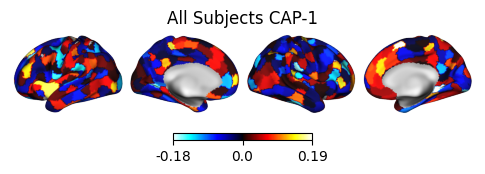

[01/27/26 14:06:51] WARNING  2026-01-27 14:06:51,392 neurocaps.analysis.cap._internals.surface        ]8;id=559980;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\surface.py\surface.py]8;;\:]8;id=189071;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\surface.py#60\60]8;;\
                             [WARNING] TypeError raised by neuromaps due to changes in pathlib.py in               
                             Python 3.12 Converting NIfTI image into a temporary nii.gz file (which                
                             will be automatically deleted afterwards) [TEMP FILE:                                 
                             C:\Users\donis\AppData\Local\Temp\tmp7i86ikpd.nii.gz]                                 

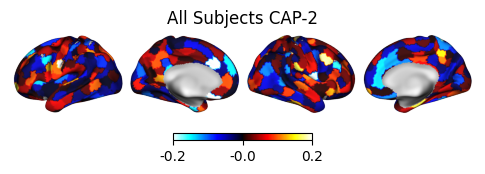

[01/27/26 14:06:55] WARNING  2026-01-27 14:06:55,107 neurocaps.analysis.cap._internals.surface        ]8;id=939707;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\surface.py\surface.py]8;;\:]8;id=833070;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\surface.py#60\60]8;;\
                             [WARNING] TypeError raised by neuromaps due to changes in pathlib.py in               
                             Python 3.12 Converting NIfTI image into a temporary nii.gz file (which                
                             will be automatically deleted afterwards) [TEMP FILE:                                 
                             C:\Users\donis\AppData\Local\Temp\tmp_sscmjy7.nii.gz]                                 

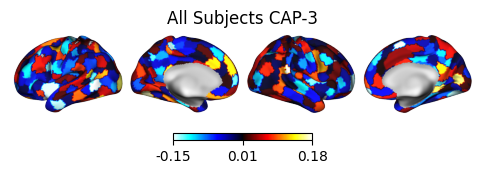

Generating Surface Plots [GROUP: All Subjects]:   0%|          | 0/3 [00:00<?, ?it/s]

[01/27/26 14:06:59] WARNING  2026-01-27 14:06:59,356 neurocaps.analysis.cap._internals.surface        ]8;id=373805;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\surface.py\surface.py]8;;\:]8;id=464602;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\surface.py#60\60]8;;\
                             [WARNING] TypeError raised by neuromaps due to changes in pathlib.py in               
                             Python 3.12 Converting NIfTI image into a temporary nii.gz file (which                
                             will be automatically deleted afterwards) [TEMP FILE:                                 
                             C:\Users\donis\AppData\Local\Temp\tmpt2i20510.nii.gz]                                 

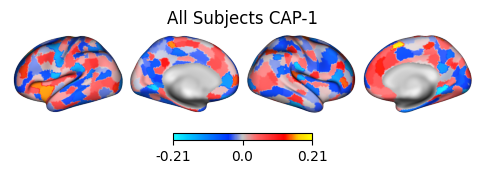

Generating Surface Plots [GROUP: All Subjects]:  33%|███▎      | 1/3 [00:04<00:08,  4.27s/it]

[01/27/26 14:07:02] WARNING  2026-01-27 14:07:02,969 neurocaps.analysis.cap._internals.surface        ]8;id=452448;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\surface.py\surface.py]8;;\:]8;id=934557;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\surface.py#60\60]8;;\
                             [WARNING] TypeError raised by neuromaps due to changes in pathlib.py in               
                             Python 3.12 Converting NIfTI image into a temporary nii.gz file (which                
                             will be automatically deleted afterwards) [TEMP FILE:                                 
                             C:\Users\donis\AppData\Local\Temp\tmprukaos0w.nii.gz]                                 

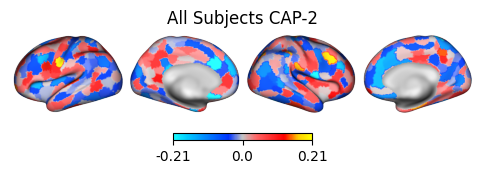

Generating Surface Plots [GROUP: All Subjects]:  67%|██████▋   | 2/3 [00:07<00:03,  3.87s/it]

[01/27/26 14:07:06] WARNING  2026-01-27 14:07:06,189 neurocaps.analysis.cap._internals.surface        ]8;id=138836;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\surface.py\surface.py]8;;\:]8;id=865799;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\surface.py#60\60]8;;\
                             [WARNING] TypeError raised by neuromaps due to changes in pathlib.py in               
                             Python 3.12 Converting NIfTI image into a temporary nii.gz file (which                
                             will be automatically deleted afterwards) [TEMP FILE:                                 
                             C:\Users\donis\AppData\Local\Temp\tmpkw7kiclv.nii.gz]                                 

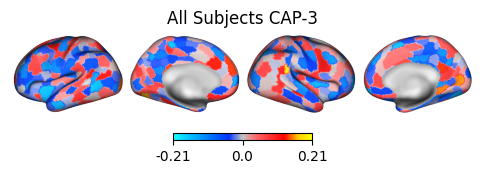

Generating Surface Plots [GROUP: All Subjects]: 100%|██████████| 3/3 [00:11<00:00,  3.69s/it]


In [30]:
from matplotlib.colors import LinearSegmentedColormap

colors = [
    "#1bfffe",
    "#00ccff",
    "#0099ff",
    "#0066ff",
    "#0033ff",
    "#c4c4c4",
    "#ff6666",
    "#ff3333",
    "#FF0000",
    "#ffcc00",
    "#FFFF00",
]

plot_kwargs = PlotDefaults.caps2surf()
plot_kwargs.update(dict(cmap="cold_hot", layout="row", size=(500, 100)))

cap_analysis.caps2surf(**plot_kwargs)

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cold_hot", colors, N=256)

plot_kwargs = PlotDefaults.caps2surf()
plot_kwargs.update(dict(cmap=custom_cmap, size=(500, 100), layout="row", surface="veryinflated", color_range=(-0.21, 0.21)))

cap_analysis.caps2surf(progress_bar=True, **plot_kwargs)

 <font size="6">CAPs to NifTIs </font>

 <font size="3">CAPs can also be projected onto the parcellation and saved as NifTI files. These same files can also be saved when using `self.caps2surf`. Additionally, this function also has the `knn_dict` parameter.</font>

In [31]:
cap_analysis.caps2niftis(
    output_dir=output_dir, suffix_filename="for_neurocaps_demo", progress_bar=True
)

Generating Statistical Maps [GROUP: All Subjects]: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]


<font size="6">CAPs to Radar Plots </font>

 <font size="3">Radar plots showing the cosine similarity between each network and the positive ("High Amplitude") and negative ("Low Amplitude") activations in each CAP. Since this function assumes that the matrix subjected to kmeans clustering was standardized, "High Amplitude" represents values above the mean (0) and "Low Amplitude" represents values below the mean (0). During calculation of the "Low Amplitude" cosine similarity, the inverse is computed to turn this similarity positive for visualization purposes.</font>

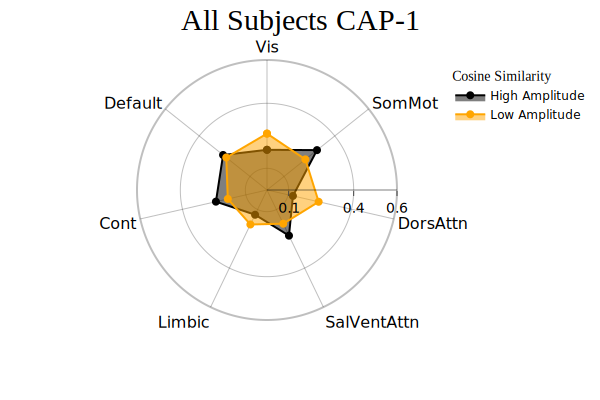

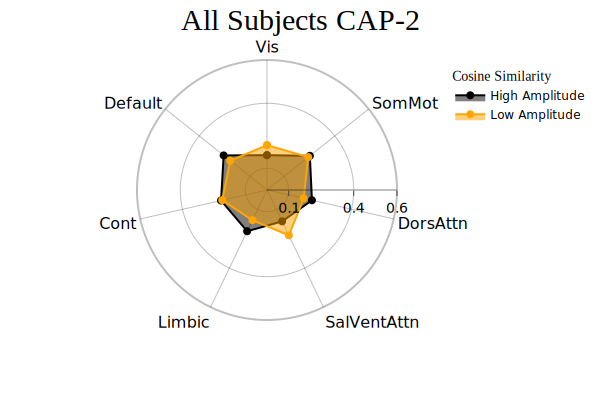

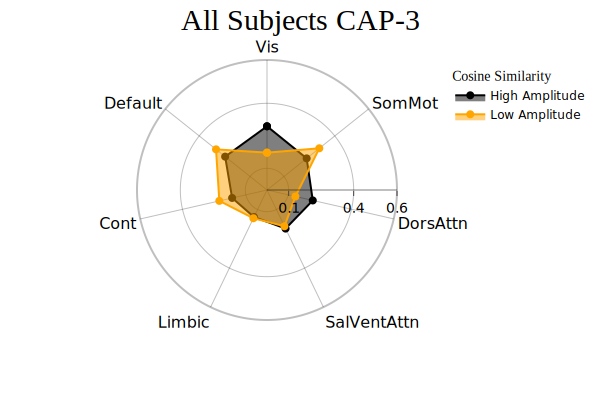

In [32]:
radialaxis = {
    "showline": True,
    "linewidth": 2,
    "linecolor": "rgba(0, 0, 0, 0.25)",
    "gridcolor": "rgba(0, 0, 0, 0.25)",
    "ticks": "outside",
    "tickfont": {"size": 14, "color": "black"},
    "range": [0, 0.6],
    "tickvals": [0.1, "", "", 0.4, "", "", 0.6],
}

legend = {
    "yanchor": "top",
    "y": 0.99,
    "x": 0.99,
    "title_font_family": "Times New Roman",
    "font": {"size": 12, "color": "black"},
}

colors = {"High Amplitude": "black", "Low Amplitude": "orange"}

plot_kwargs = PlotDefaults.caps2radar()
plot_kwargs.update(
    dict(
        radialaxis=radialaxis,
        height=400,
        width=600,
        color_discrete_map=colors,
        legend=legend,
    )
)

cap_analysis.caps2radar(**plot_kwargs)

 <font size="3">The cosine similarities are stored in the `self.cosine_similarity` property.</font>

In [33]:
import pandas as pd

df = pd.DataFrame(cap_analysis.cosine_similarity["All Subjects"]["CAP-1"])

df["Regions"] = cap_analysis.cosine_similarity["All Subjects"]["Regions"]

print(df)

   High Amplitude  Low Amplitude      Regions
0        0.185497       0.260337          Vis
1        0.295110       0.226627       SomMot
2        0.122767       0.244456     DorsAttn
3        0.233854       0.172730  SalVentAttn
4        0.126798       0.176608       Limbic
5        0.241802       0.185526         Cont
6        0.259253       0.240475      Default


  <font size="6">Using Custom Parcellations </font>

 <font size="3">The NeuroCAPs package uses Nilearn to obtain the "maps" and "nodes" for the Schaefer and AAL atlases, then uses some Python code to create a list of "regions" using the "nodes" list. NeuroCAPs can also accept additional parcellations. Below is an example using the HCPex atlas from [wayalan Github](https://github.com/wayalan/HCPex/) for the `CAP` class.
 
 Refer to [Tutorial 7](https://neurocaps.readthedocs.io/en/stable/examples/custom.html) for the different methods to create a Custom parcellation
 </font>

In [34]:
from neurocaps.utils import fetch_preset_parcel_approach

# Creating new subject timeseries that has 426 columns
subject_timeseries = simulate_subject_timeseries(n_subs=8, n_runs=3, shape=(100, 426))

cap_analysis = CAP(parcel_approach=fetch_preset_parcel_approach("HCPex"))

cap_analysis.get_caps(
    subject_timeseries=subject_timeseries,
    n_clusters=range(2, 11),
    cluster_selection_method="variance_ratio",
)

[01/27/26 14:07:16] INFO     2026-01-27 14:07:16,404 neurocaps.analysis.cap._internals.cluster [INFO] ]8;id=637030;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py\cluster.py]8;;\:]8;id=110446;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py#47\47]8;;\
                             No groups specified. Using default group 'All Subjects' containing all                
                             subject IDs from `subject_timeseries`. The `groups` dictionary will                   
                             remain fixed unless the `CAP` class is re-initialized or                              
                             `clear_groups()` is used.                                                             

                    INFO     2026-01-27 14:07:16,694 neurocaps.analysis.cap._internals.cluster       ]8;id=632195;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py\cluster.py]8;;\:]8;id=835746;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py#281\281]8;;\
                             [INFO] [GROUP: All Subjects | METHOD: variance_ratio] Optimal cluster                 
                             size is 2.                                                                            

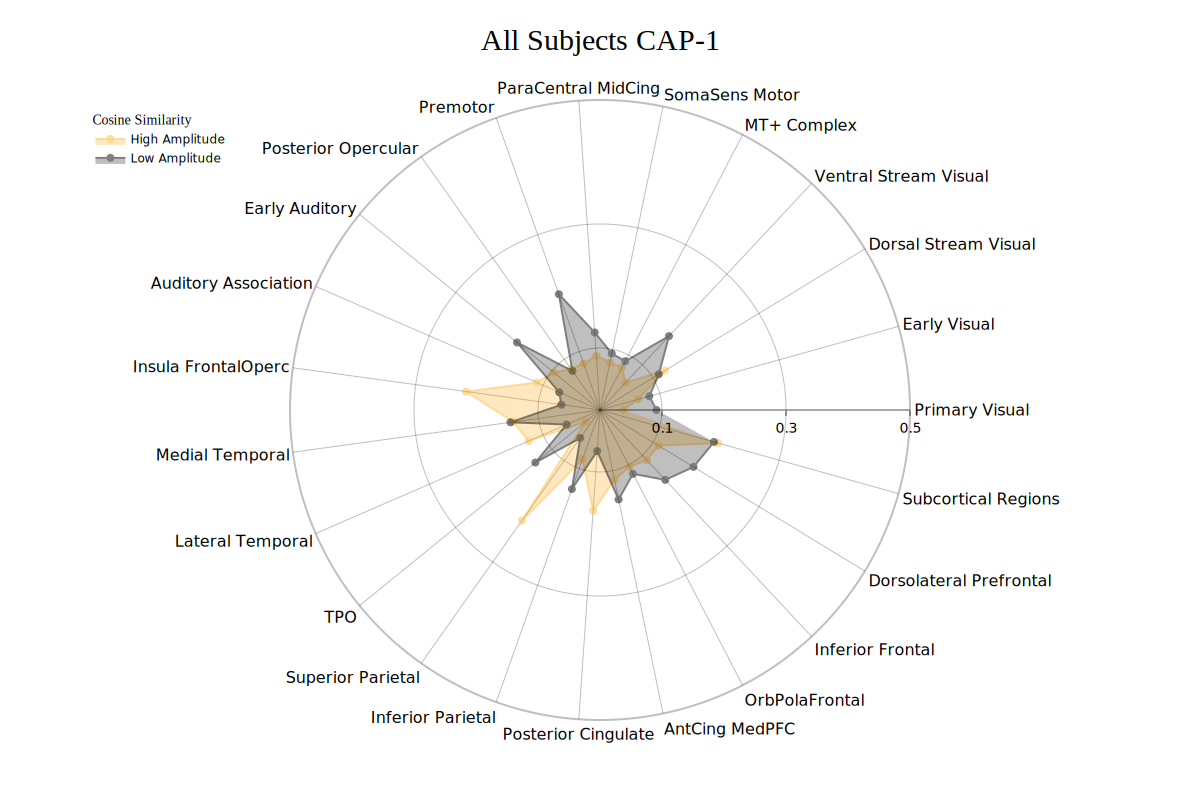

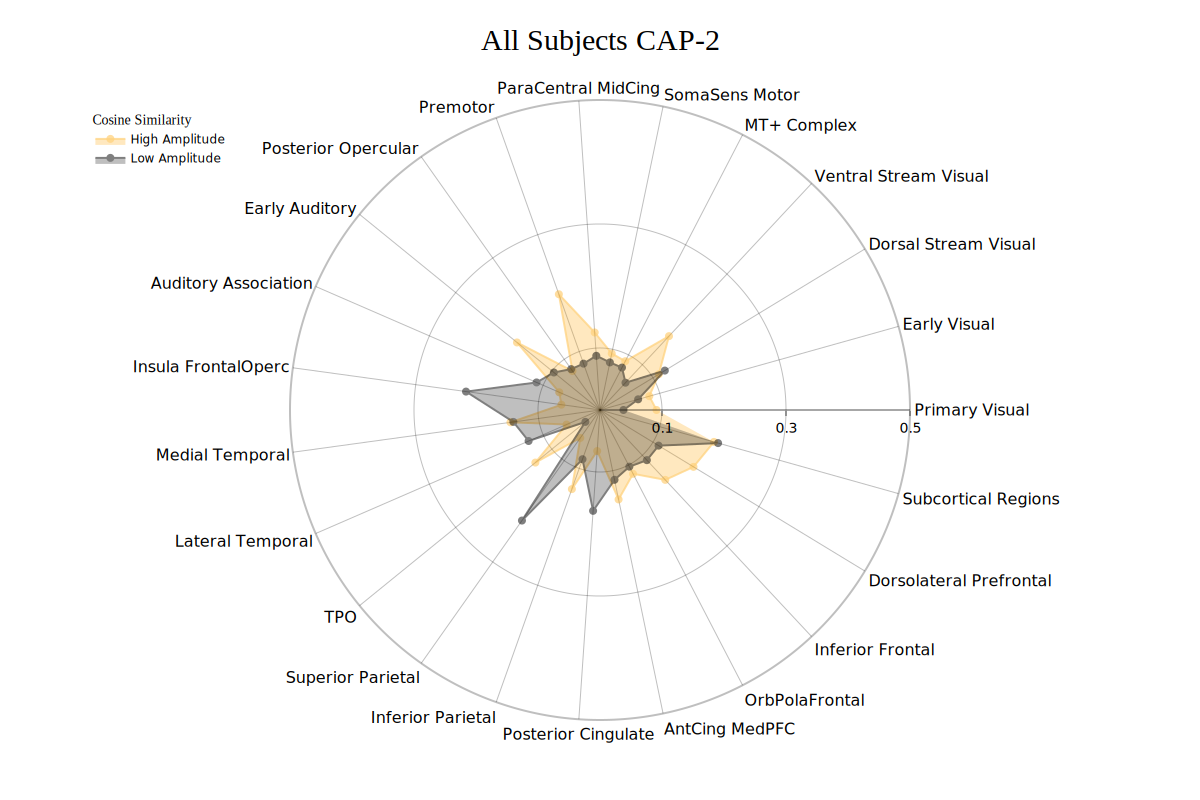

In [35]:
radialaxis = {
    "showline": True,
    "linewidth": 2,
    "linecolor": "rgba(0, 0, 0, 0.25)",
    "gridcolor": "rgba(0, 0, 0, 0.25)",
    "ticks": "outside",
    "tickfont": {"size": 14, "color": "black"},
    "range": [0, 0.5],
    "tickvals": [0.1, "", 0.3, "", 0.5],
}

color_discrete_map = {
    "High Amplitude": "rgba(255, 165, 0, 0.75)",
    "Low Amplitude": "black",
}

plot_kwargs = PlotDefaults.caps2radar()
plot_kwargs.update(
    dict(
        radialaxis=radialaxis,
        fill="toself",
        color_discrete_map=color_discrete_map,
    )
)

cap_analysis.caps2radar(
    use_scatterpolar=True,
    output_dir=output_dir,
    plot_output_format="html",
    **plot_kwargs,
)

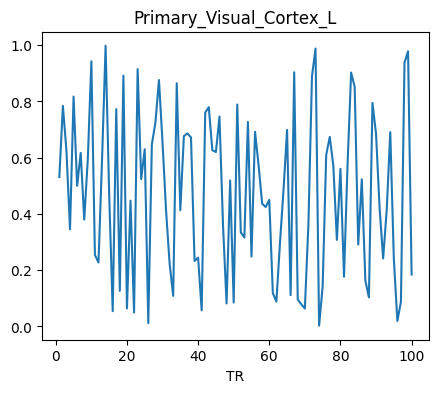

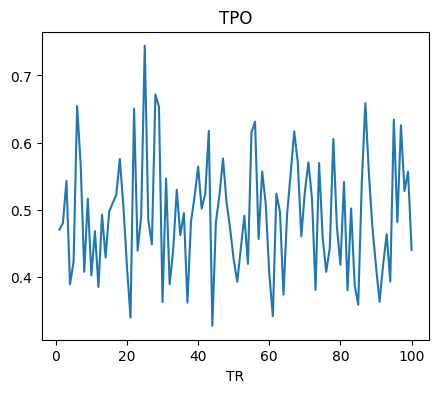

In [36]:
# Subject timeseries also acts as a setter if the `visualize_bold` method needs to be used
extractor.subject_timeseries = subject_timeseries
extractor.parcel_approach = cap_analysis.parcel_approach

plot_kwargs = PlotDefaults.visualize_bold()
plot_kwargs["figsize"] = (5, 4)

extractor.visualize_bold(
    subj_id="1",
    run=1,
    roi_indx=0,
    output_dir=output_dir,
    filename="test_bold_for_neurocaps",
    **plot_kwargs,
)

extractor.visualize_bold(subj_id="1", run=1, region="TPO", **plot_kwargs)

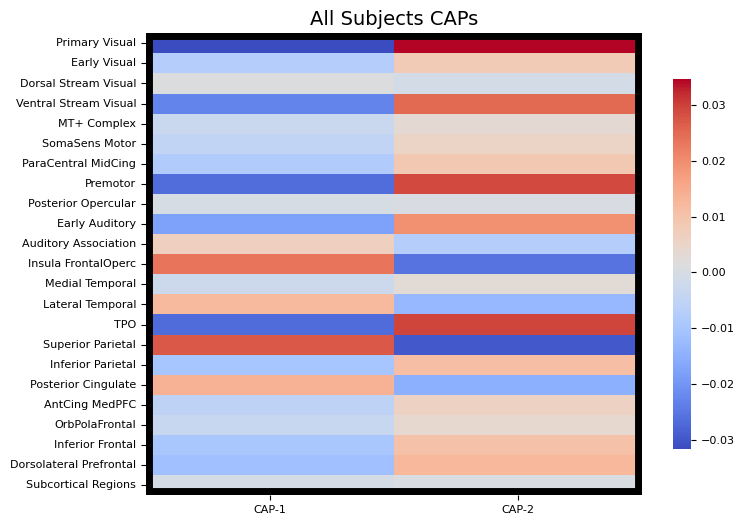

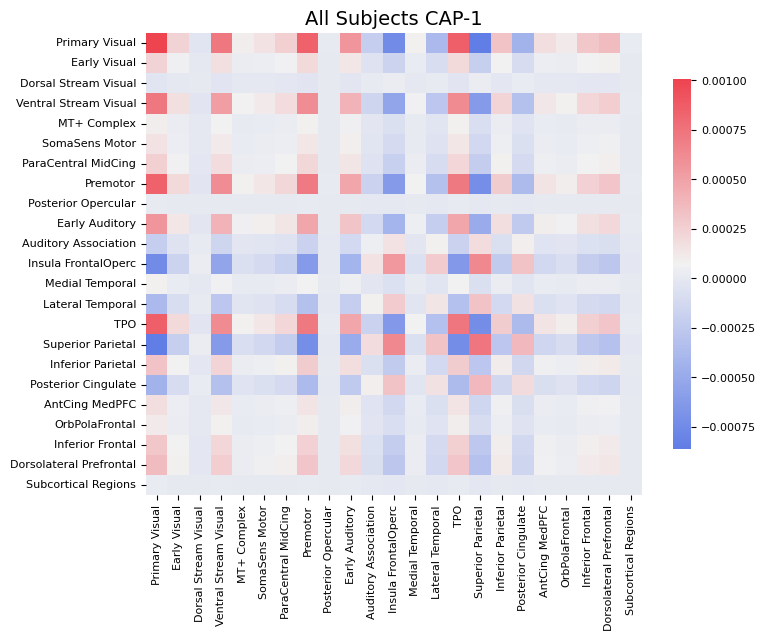

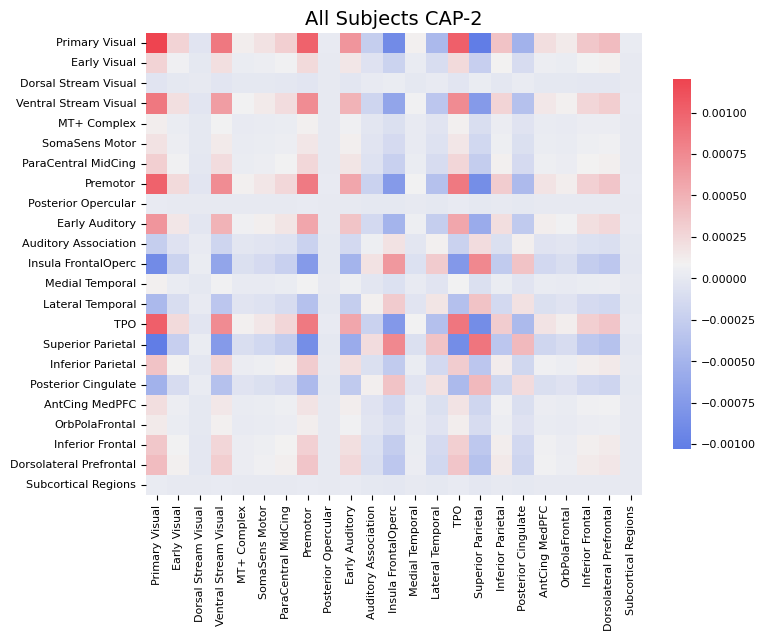

In [37]:
import seaborn as sns

sns.diverging_palette(145, 300, s=60, as_cmap=True)

palette = sns.diverging_palette(260, 10, s=80, l=55, n=256, as_cmap=True)

plot_kwargs = PlotDefaults.caps2plot()
plot_kwargs.update(dict(borderwidths=10))
cap_analysis.caps2plot(visual_scope="regions", plot_options="heatmap", **plot_kwargs)

plot_kwargs = PlotDefaults.caps2plot()
plot_kwargs.update(
    dict(
        fontsize=14,
        tight_layout=False,
        xlabel_rotation=90,
        hspace=0.3,
        cmap=palette,
    )
)

cap_analysis.caps2plot(
    visual_scope="regions",
    plot_options="outer_product",
    subplots=False,
    output_dir=output_dir,
    **plot_kwargs,
)

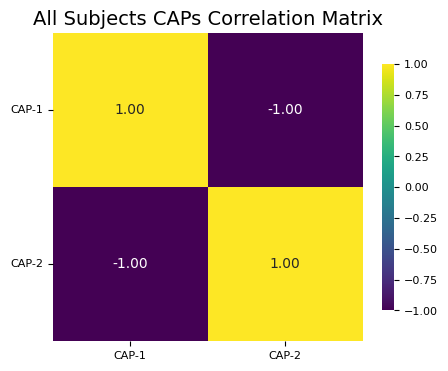

,Subject_ID,Group,Run,CAP-1,CAP-2
0,0,All Subjects,run-continuous,4.985075,3.911765
1,1,All Subjects,run-continuous,4.101266,3.493671
2,2,All Subjects,run-continuous,3.802469,3.650000
3,3,All Subjects,run-continuous,3.400000,4.049383
4,4,All Subjects,run-continuous,4.025316,3.569620
5,5,All Subjects,run-continuous,4.309859,4.083333
6,6,All Subjects,run-continuous,4.416667,3.916667
7,7,All Subjects,run-continuous,4.179487,3.558442


In [38]:
plot_kwargs = PlotDefaults.caps2corr()
plot_kwargs.update(dict(annot=True, cmap="viridis", fmt=".2f", figsize=(5, 4)))

cap_analysis.caps2corr(output_dir=output_dir, **plot_kwargs)

outputs = cap_analysis.calculate_metrics(
    subject_timeseries=subject_timeseries,
    tr=2,
    continuous_runs=True,
    metrics=["persistence", "transition_probability"],
    output_dir=output_dir,
)

outputs["persistence"]

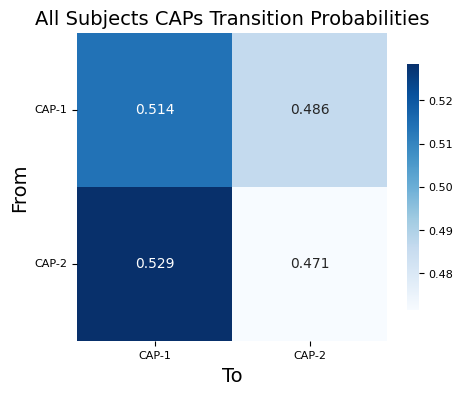

,CAP-1,CAP-2
From/To,,
CAP-1,0.513874,0.486126
CAP-2,0.528537,0.471463


In [39]:
plot_kwargs = PlotDefaults.transition_matrix()
plot_kwargs.update(
    dict(
        annot=True,
        fmt=".3f",
        return_df=True,
        figsize=(5, 4),
        cmap="Blues",
    )
)

trans_df = transition_matrix(trans_dict=outputs["transition_probability"], **plot_kwargs)

trans_df["All Subjects"]

<font size="6">Using KNN to Fix Surface Plot Visualization Issues </font>

<font size="3">This is primarily for parcellations outside of Schaefer and AAL. If you notice that your surface plots are sparse due to having many unassigned cortical surface voxels (i.e. cortical parcellations converted into volumetric format), there is a `knn_dict` parameter in both `self.caps2surf` and `self.caps2niftis`, which uses the Schaefer atlas as a reference atlas to determine the background boundaries so that k-nearest neighbors interpolation can be used. The sub-keys are "k" and "resolution_mm" for the resolution of Schaefer to use as the reference. **This process may take a few minutes depending on your computer**.</font>

[01/27/26 14:07:18] WARNING  2026-01-27 14:07:18,102 neurocaps.analysis.cap._internals.surface        ]8;id=494371;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\surface.py\surface.py]8;;\:]8;id=231559;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\surface.py#60\60]8;;\
                             [WARNING] TypeError raised by neuromaps due to changes in pathlib.py in               
                             Python 3.12 Converting NIfTI image into a temporary nii.gz file (which                
                             will be automatically deleted afterwards) [TEMP FILE:                                 
                             C:\Users\donis\AppData\Local\Temp\tmpsi6u78fo.nii.gz]                                 

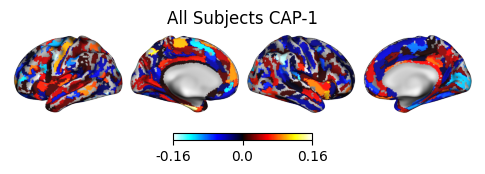

                    WARNING  2026-01-27 14:07:18,567 neurocaps.analysis.cap._internals.surface        ]8;id=333028;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\surface.py\surface.py]8;;\:]8;id=542555;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\surface.py#60\60]8;;\
                             [WARNING] TypeError raised by neuromaps due to changes in pathlib.py in               
                             Python 3.12 Converting NIfTI image into a temporary nii.gz file (which                
                             will be automatically deleted afterwards) [TEMP FILE:                                 
                             C:\Users\donis\AppData\Local\Temp\tmpsa0gmuob.nii.gz]                                 

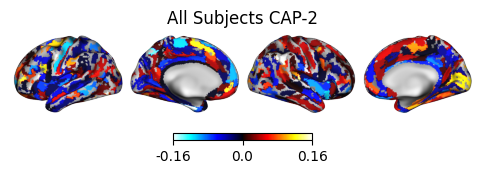

                    WARNING  2026-01-27 14:07:18,816 neurocaps.analysis.cap.cap [WARNING]               ]8;id=205624;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\cap.py\cap.py]8;;\:]8;id=503765;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\cap.py#1454\1454]8;;\
                             'reference_atlas' not specified in `knn_dict`. The default reference atlas            
                             is 'Schaefer'.                                                                        

                    WARNING  2026-01-27 14:07:18,819 neurocaps.analysis.cap.cap [WARNING] Defaulting to ]8;id=479870;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\cap.py\cap.py]8;;\:]8;id=164920;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\cap.py#1462\1462]8;;\
                             1mm resolution for the Schaefer atlas since 'resolution_mm' was not                   
                             specified in `knn_dict`.                                                              

Generating Surface Plots [GROUP: All Subjects]:   0%|          | 0/2 [00:00<?, ?it/s]

[01/27/26 14:07:21] WARNING  2026-01-27 14:07:21,037 neurocaps.analysis.cap._internals.surface        ]8;id=526238;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\surface.py\surface.py]8;;\:]8;id=693195;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\surface.py#60\60]8;;\
                             [WARNING] TypeError raised by neuromaps due to changes in pathlib.py in               
                             Python 3.12 Converting NIfTI image into a temporary nii.gz file (which                
                             will be automatically deleted afterwards) [TEMP FILE:                                 
                             C:\Users\donis\AppData\Local\Temp\tmpi068momz.nii.gz]                                 

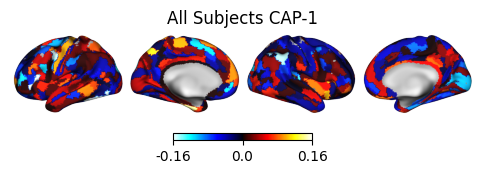

Generating Surface Plots [GROUP: All Subjects]:  50%|█████     | 1/2 [00:02<00:02,  2.51s/it]

[01/27/26 14:07:23] WARNING  2026-01-27 14:07:23,433 neurocaps.analysis.cap._internals.surface        ]8;id=588681;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\surface.py\surface.py]8;;\:]8;id=184986;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\surface.py#60\60]8;;\
                             [WARNING] TypeError raised by neuromaps due to changes in pathlib.py in               
                             Python 3.12 Converting NIfTI image into a temporary nii.gz file (which                
                             will be automatically deleted afterwards) [TEMP FILE:                                 
                             C:\Users\donis\AppData\Local\Temp\tmp9rf28oxs.nii.gz]                                 

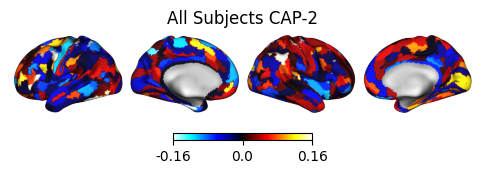

Generating Surface Plots [GROUP: All Subjects]: 100%|██████████| 2/2 [00:04<00:00,  2.45s/it]


In [40]:
# Plotting with caps2surf; showing original and version using knn to reduce gaps
plot_kwargs = PlotDefaults.caps2surf()
plot_kwargs.update(dict(size=(500, 100), layout="row", color_range=[-0.16, 0.16]))
cap_analysis.caps2surf(method="nearest", **plot_kwargs)

cap_analysis.caps2surf(
    method="nearest",
    knn_dict={"k": 5, "method": "majority_vote"},
    save_stat_maps=True,
    output_dir=output_dir,
    progress_bar=True,
    **plot_kwargs,
)

Quick example using Schaefer 4s for "Custom" ``parcel_approach``.

<font size="3">Visualizing CAPs as surface plots using `self.caps2surf` method.</font>

In [41]:
import subprocess

from neurocaps.utils import generate_custom_parcel_approach

# Fetching atlas NiFTI image and labels from Github
if sys.platform != "win32":
    cmd = [
        [
            "wget",
            "-q",
            "-P",
            output_dir,
            "https://github.com/PennLINC/AtlasPack/raw/main/atlas-4S156Parcels_dseg.tsv",
        ],
    ]
else:
    cmd = [
        [
            "curl",
            "-L",
            "-o",
            f"{output_dir}\\atlas-4S156Parcels_dseg.tsv",
            "https://github.com/PennLINC/AtlasPack/raw/main/atlas-4S156Parcels_dseg.tsv",
        ],
    ]

for command in cmd:
    subprocess.run(command, check=True)

# For this parcellation, the metadata contains the labels and the network mappings though
# certain nodes in the Cerebellum, Subcortical, and Thalamus have NaN values in the
# column denoting network affiliation
df = pd.read_csv(
    r"neurocaps_demo\atlas-4S156Parcels_dseg.tsv",
    sep="\t",
)

# Replacing null values in the "network_label" column with values in "atlas_name"
df["network_label"] = np.where(df["network_label"].isnull(), df["atlas_name"], df["network_label"])

# Simplifying names for for certain names in "network_label"
df.loc[df["network_label"].str.contains("Subcortical", na=False), "network_label"] = "Subcortical"
df.loc[df["network_label"].str.contains("Thalamus", na=False), "network_label"] = "Thalamus"

# Create empty file for demonstration purposes
with open(r"neurocaps_demo\temp_parc_map.nii.gz", "w") as f:
    pass

# Creating custom parcel approach dictionary
parcel_approach = generate_custom_parcel_approach(
    df,
    maps_path=r"neurocaps_demo\temp_parc_map.nii.gz",
    column_map={"nodes": "label", "regions": "network_label"},
)

The following code creates a lateralized version of the ``parcel_approach``. Note that the
lateralization information is specific case in ``CAP.caps2plot`` when ``visual_scope`` is set to
"nodes" and the ``add_custom_node_labels`` kwarg is True.

In [42]:
# Create a hemisphere column
df["hemisphere_labels"] = df["hemisphere_labels"] = df["label"].str.extract(r"^(LH|RH)")

# Creating custom parcel approach dictionary
parcel_approach = generate_custom_parcel_approach(
    df,
    maps_path=r"neurocaps_demo\temp_parc_map.nii.gz",
    column_map={"nodes": "label", "regions": "network_label", "hemispheres": "hemisphere_labels"},
    hemisphere_map={"lh": ["LH"], "rh": ["RH"]},
)

In [43]:
subject_timeseries = simulate_subject_timeseries(n_subs=8, n_runs=3, shape=(50, 156))

cap_analysis.parcel_approach = parcel_approach
cap_analysis.get_caps(subject_timeseries=subject_timeseries, n_clusters=3)

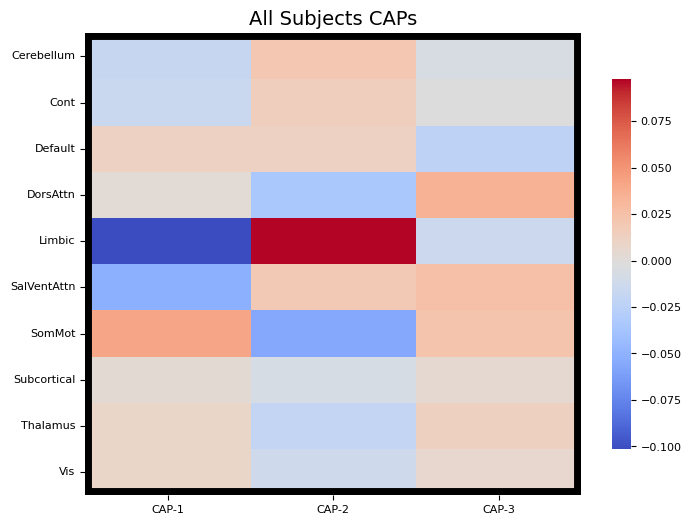

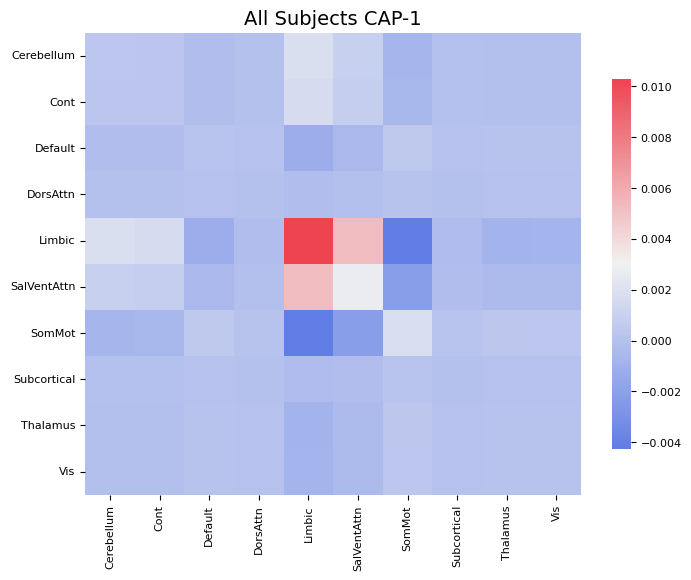

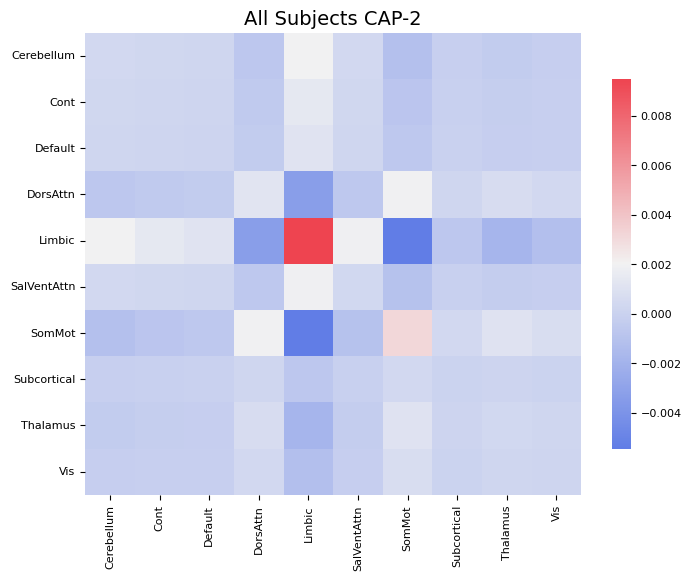

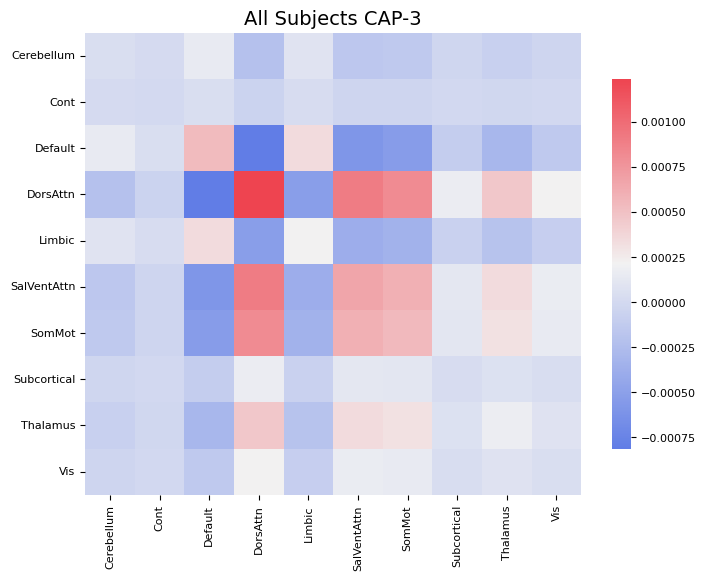

In [44]:
import seaborn as sns

sns.diverging_palette(145, 300, s=60, as_cmap=True)

palette = sns.diverging_palette(260, 10, s=80, l=55, n=256, as_cmap=True)

plot_kwargs = PlotDefaults.caps2plot()
plot_kwargs.update(dict(borderwidths=10))
cap_analysis.caps2plot(visual_scope="regions", plot_options="heatmap", **plot_kwargs)

plot_kwargs = PlotDefaults.caps2plot()
plot_kwargs.update(
    dict(
        fontsize=14,
        tight_layout=False,
        xlabel_rotation=90,
        hspace=0.3,
        cmap=palette,
    )
)

cap_analysis.caps2plot(
    visual_scope="regions",
    plot_options="outer_product",
    subplots=False,
    output_dir=output_dir,
    **plot_kwargs,
)

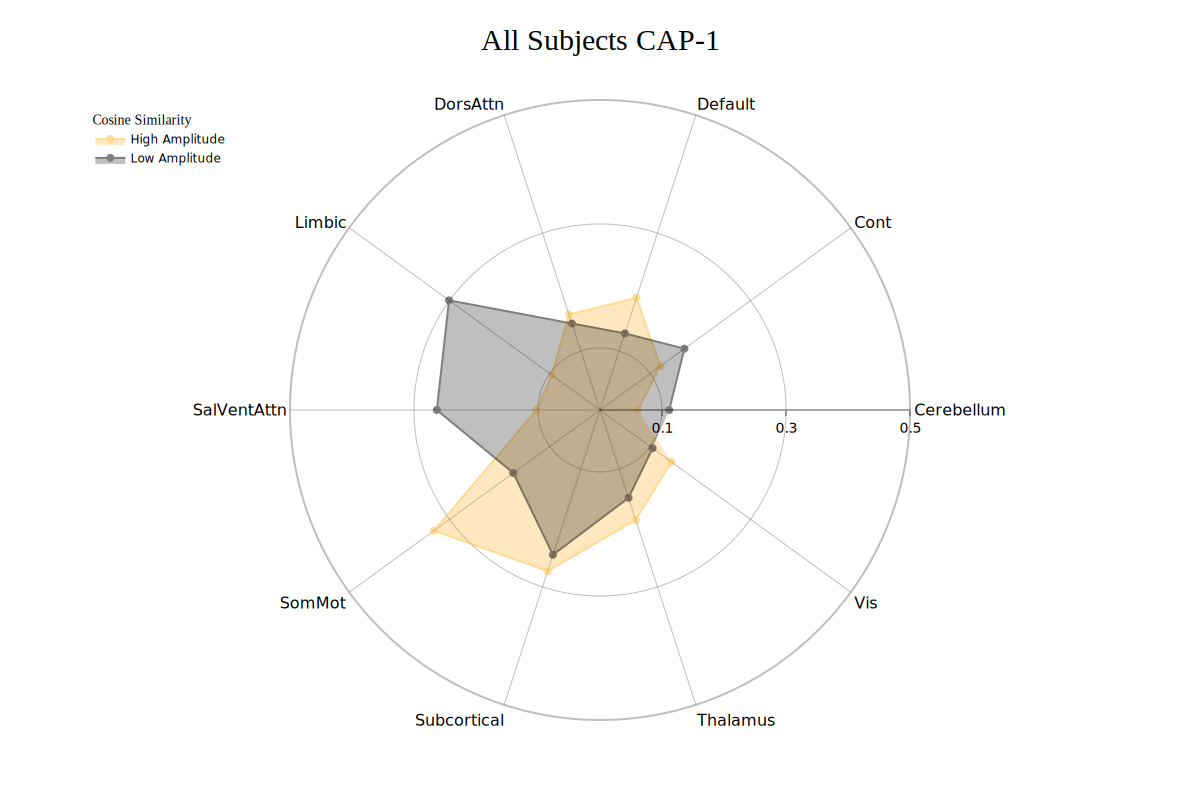

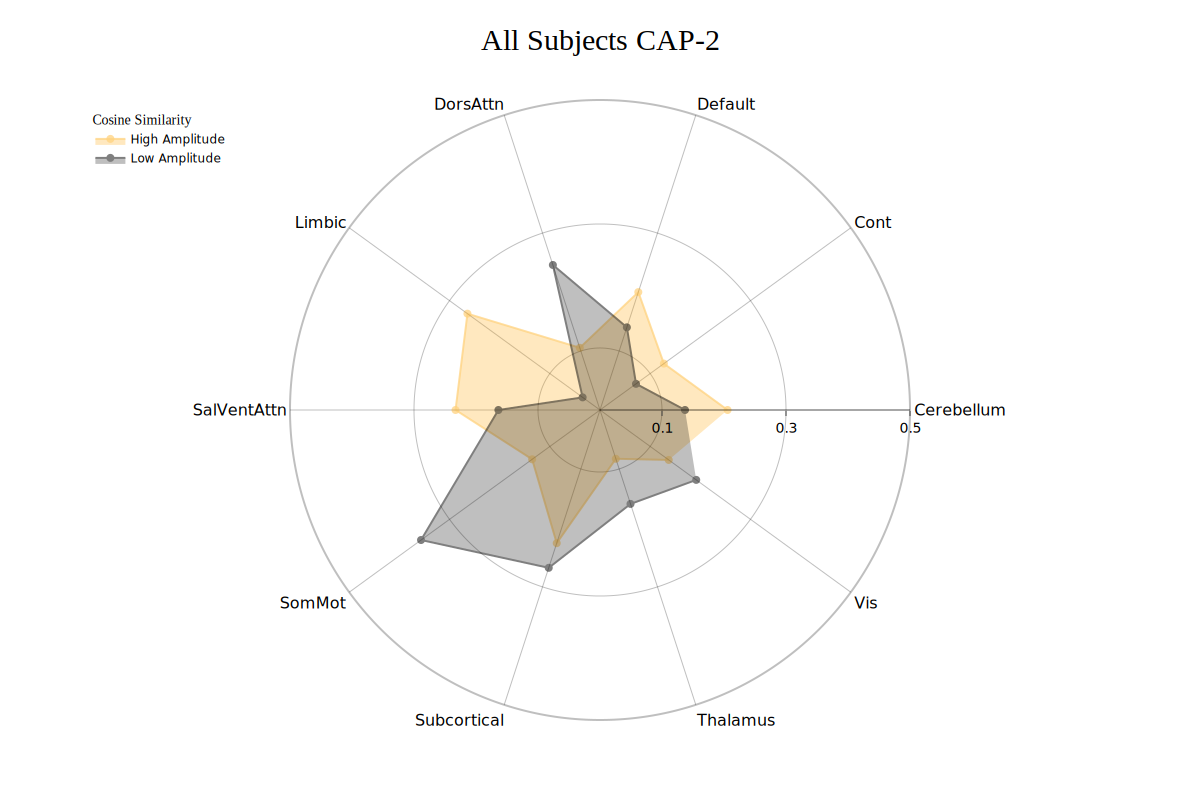

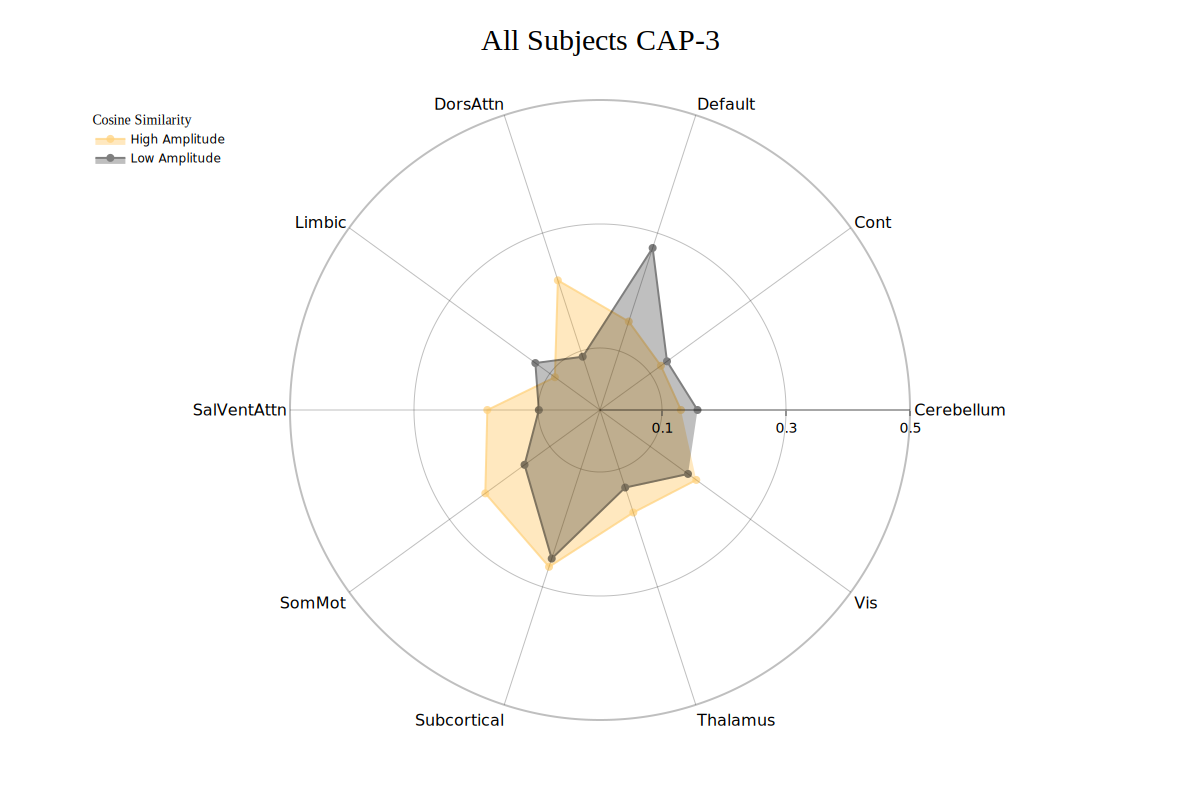

In [45]:
radialaxis = {
    "showline": True,
    "linewidth": 2,
    "linecolor": "rgba(0, 0, 0, 0.25)",
    "gridcolor": "rgba(0, 0, 0, 0.25)",
    "ticks": "outside",
    "tickfont": {"size": 14, "color": "black"},
    "range": [0, 0.5],
    "tickvals": [0.1, "", 0.3, "", 0.5],
}

color_discrete_map = {
    "High Amplitude": "rgba(255, 165, 0, 0.75)",
    "Low Amplitude": "black",
}

plot_kwargs = PlotDefaults.caps2radar()
plot_kwargs.update(
    dict(
        radialaxis=radialaxis,
        fill="toself",
        color_discrete_map=color_discrete_map,
    )
)

cap_analysis.caps2radar(
    use_scatterpolar=True, output_dir=output_dir, plot_output_format="html", **plot_kwargs
)

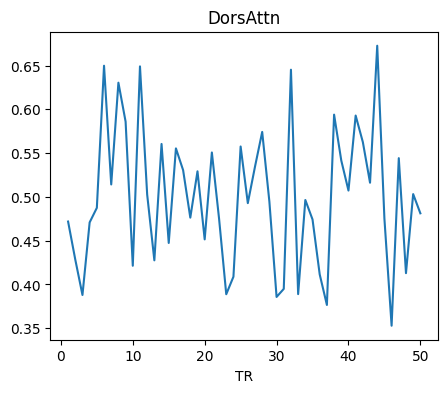

In [46]:
extractor.subject_timeseries = subject_timeseries
extractor.parcel_approach = parcel_approach

plot_kwargs = PlotDefaults.visualize_bold()
plot_kwargs["figsize"] = (5, 4)

extractor.visualize_bold(subj_id="1", run=1, region="DorsAttn", **plot_kwargs)

<font size="6">Types </font>

<font size="3">Type definitions are offered in the `neurocaps.typing` module to assist in building the correct dictionary structure for parcellation configurations,
parcellation approaches, and subject timeseries when using a static type checker such as [Pylance](https://marketplace.visualstudio.com/items?itemName=ms-python.vscode-pylance).</font>

In [47]:
from neurocaps.typing import *

schaefer_config: SchaeferParcelConfig = {"n_rois": 100, "yeo_networks": 7, "resolution_mm": 1}

parcel_config: ParcelConfig = {"Schaefer": schaefer_config}

# Set new parcellation configuration
extractor.parcel_approach = parcel_config

 <font size="3">Removes the files and directories generated in this demo.</font>

In [48]:
import shutil

shutil.rmtree("neurocaps_demo", ignore_errors=True)